In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import random
from sklearn import metrics
import seaborn as sea
import pickle

# -------------------- PARAMETERS --------------------

In [2]:
# name of the file with dataset
filename = 'mtg_dataset_02_2023'

In [3]:
# importing dataset from the .cvs file with chosen name
df = pd.read_csv('Datasets\\' + filename + '.csv', sep=';')

In [4]:
# name of the folder where trained models are imported from
import_folder = 'Models\\'

In [5]:
# which columns are treated as numeric
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [6]:
# columns to exclude
columns_to_exclude = ['name','set']
colors_excludes = ['color', 'devotion','manasymbols','price']

In [7]:
# paramenters of random number generator
random_state = 0
random.seed(random_state)

# --------------------------- DATA ---------------------------

In [8]:
# dataset preview
df.head()

,name,set,dfc,prints,layout,flavor_text,type_creature,type_artifact,type_enchantment,type_planeswalker,...,custom_cheatinto_play,custom_ritual,custom_no_maximum,custom_wheel,custom_extra_combat,custom_pillow_fort,custom_land_destruction,custom_win_game,custom_lose_game,custom_poison
0,Fury Sliver,tsp,0.0,3,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kor Outfitter,zen,0.0,2,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Siren Lookout,xln,0.0,1,normal,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Venerable Knight,eld,0.0,1,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Wildcall,ugin,0.0,2,normal,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
file = open(import_folder + 'colorless', 'rb')
model_colorless = pickle.load(file)
file.close()

In [10]:
file = open(import_folder + 'colors_B', 'rb')
model_colors_B = pickle.load(file)
file.close()

In [11]:
file = open(import_folder + 'colors_G', 'rb')
model_colors_G = pickle.load(file)
file.close()

In [12]:
file = open(import_folder + 'colors_R', 'rb')
model_colors_R = pickle.load(file)
file.close()

In [13]:
file = open(import_folder + 'colors_U', 'rb')
model_colors_U = pickle.load(file)
file.close()

In [14]:
file = open(import_folder + 'colors_W', 'rb')
model_colors_W = pickle.load(file)
file.close()

# -------------------- FUNCTIONS --------------------

In [15]:
# function to exclude unwanted columns
def prepare_for_model(data, decision_class, numeric_only, columns_excludes):
    y = data[decision_class]
    x = data.loc[:, ~data.columns.isin(columns_to_exclude)]
    
    for exclude in columns_excludes:
        x = x.loc[:, ~x.columns.str.contains(exclude)]
        
    if numeric_only == True:
        x = x.select_dtypes(include=numerics)
        
    if decision_class not in x:
        x[decision_class] = y
    
    return x

# -------------------- CARD PREDICTION --------------------

In [16]:
card_name = 'Damnation'

In [17]:
card_sample = df.loc[df['name'] == card_name].sample(n=1, random_state=0)
card_sample

,name,set,dfc,prints,layout,flavor_text,type_creature,type_artifact,type_enchantment,type_planeswalker,...,custom_cheatinto_play,custom_ritual,custom_no_maximum,custom_wheel,custom_extra_combat,custom_pillow_fort,custom_land_destruction,custom_win_game,custom_lose_game,custom_poison
31333,Damnation,2x2,0.0,7,normal,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print("Card predictions for:")
print(card_sample['name'].values.tolist())
print('')

df_results = pd.DataFrame(columns=['color', 'NO', 'YES'])

x = prepare_for_model(card_sample, 'colorless', True, colors_excludes)
prediction_colorless = model_colorless.predict_proba(x.loc[:, ~x.columns.isin(['colorless'])])
row_colorless = {'color':'colorless', 'NO':prediction_colorless[0][0], 'YES':prediction_colorless[0][1]}
df_results = df_results.append(row_colorless, ignore_index=True)

x = prepare_for_model(card_sample, 'colors_B', True, colors_excludes)
prediction_black = model_colors_B.predict_proba(x.loc[:, ~x.columns.isin(['colors_B'])])
row_black = {'color':'black', 'NO':prediction_black[0][0], 'YES':prediction_black[0][1]}
df_results = df_results.append(row_black, ignore_index=True)

x = prepare_for_model(card_sample, 'colors_G', True, colors_excludes)
prediction_green = model_colors_G.predict_proba(x.loc[:, ~x.columns.isin(['colors_G'])])
row_green = {'color':'green', 'NO':prediction_green[0][0], 'YES':prediction_green[0][1]}
df_results = df_results.append(row_green, ignore_index=True)

x = prepare_for_model(card_sample, 'colors_R', True, colors_excludes)
prediction_red = model_colors_R.predict_proba(x.loc[:, ~x.columns.isin(['colors_R'])])
row_red = {'color':'red', 'NO':prediction_red[0][0], 'YES':prediction_red[0][1]}
df_results = df_results.append(row_red, ignore_index=True)

x = prepare_for_model(card_sample, 'colors_U', True, colors_excludes)
prediction_blue = model_colors_U.predict_proba(x.loc[:, ~x.columns.isin(['colors_U'])])
row_blue = {'color':'blue', 'NO':prediction_blue[0][0], 'YES':prediction_blue[0][1]}
df_results = df_results.append(row_blue, ignore_index=True)

x = prepare_for_model(card_sample, 'colors_W', True, colors_excludes)
prediction_white = model_colors_W.predict_proba(x.loc[:, ~x.columns.isin(['colors_W'])])
row_white = {'color':'white', 'NO':prediction_white[0][0], 'YES':prediction_white[0][1]}
df_results = df_results.append(row_white, ignore_index=True)

Card predictions for:
['Damnation']



In [19]:
df_results

,color,NO,YES
0,colorless,0.8000,0.2000
1,black,0.1200,0.8800
2,green,0.8750,0.1250
3,red,0.9100,0.0900
4,blue,0.9150,0.0850
5,white,0.4975,0.5025


<AxesSubplot:xlabel='color', ylabel='YES'>

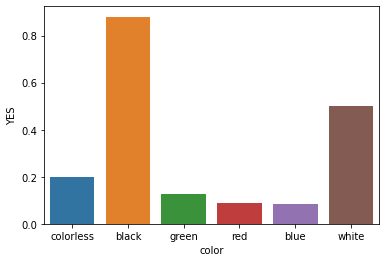

In [20]:
sea.barplot(data=df_results, x="color", y="YES")